In [16]:
import itertools as itt
import pathlib as pl
from configparser import ConfigParser

import numpy as np
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from webcolors import name_to_rgb

import matplotlib.pyplot as plt
import seaborn as sns
import joblib as jl

from src.root_path import config_path

from src.data.rasters import load_site_formated_raster
from src.metrics.consolidated_dprimes import single_cell_dprimes
from src.metrics.significance import _significance

## Load and format all required data, i.e. a dataframe

In [5]:

"""
single cell analysis: comparison between regions and context types i.e. silence, same, different.
"""


plt.style.use(['default', config_path / 'presentation.mplstyle'])

config = ConfigParser()
config.read_file(open(config_path / 'settings.ini'))
meta = {'reliability': 0.1,  # r value
        'smoothing_window': 0,  # ms
        'raster_fs': 30,
        'montecarlo': 1000,
        'zscore': True,
        'dprime_absolute': None,
        'stim_type': 'permutations',
        'alpha':0.05}
# todo, if batch analysis rerun, use the anotated line instead
# summary_DF_file = pl.Path(config['paths']['analysis_cache']) / f'211221_cxt_metrics_summary_DF_alpha_{meta}'
summary_DF_file = pl.Path(config['paths']['analysis_cache']) / '211221_cxt_metrics_summary_DF_alpha_0.05'

DF = jl.load(summary_DF_file)

def format_dataframe(DF):

    ff_analylis = DF.analysis.isin(['SC', 'fdPCA'])
    ff_corr = DF.mult_comp_corr == 'consecutive_3'

    good_cols =['analysis', 'mult_comp_corr', 'region', 'siteid',  'cellid', 'context_pair',
                'probe', 'metric', 'value']
    filtered = DF.loc[ff_analylis & ff_corr, good_cols]

    filtered['probe'] = [int(p) for p in filtered['probe']]
    filtered['context_pair'] = [f"{int(cp.split('_')[0]):02d}_{int(cp.split('_')[1]):02d}"
                                for cp in filtered['context_pair']]

    # rename metrics and analysis for ease of ploting
    filtered['metric'] = filtered['metric'].replace({'significant_abs_mass_center': 'center of mass (ms)',
                                                     'significant_abs_mean': "mean d'",
                                                     'significant_abs_sum': "integral (d'*ms)"})
    filtered['analysis'] = filtered['analysis'].replace({'SC': 'single cell',
                                                         'fdPCA': 'population',
                                                         'pdPCA': 'probewise pop',
                                                         'LDA': 'pop ceiling'})

    filtered['id'] = filtered['cellid'].fillna(value=filtered['siteid'])
    filtered = filtered.drop(columns=['cellid', 'siteid'])

    filtered['value'] = filtered['value'].fillna(value=0)

    # permutation related preprocesing.
    # creates a new column relating probe with  context pairs
    ctx = np.asarray([row.split('_') for row in filtered.context_pair], dtype=int)
    prb = np.asarray(filtered.probe, dtype=int)

    silence = ctx == 0
    same = ctx == prb[:,None]
    different = np.logical_and(~silence, ~same)

    name_arr = np.full_like(ctx, np.nan, dtype=object)
    name_arr[silence] = 'silence'
    name_arr[same] = 'same'
    name_arr[different] = 'diff'
    comp_name_arr = np.apply_along_axis('_'.join, 1, name_arr)

    # swaps clasification names to not have repetitions i.e. diff_same == same_diff
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'
    comp_name_arr[np.where(comp_name_arr == 'diff_silence')] = 'silence_diff'
    comp_name_arr[np.where(comp_name_arr == 'diff_same')] = 'same_diff'
    comp_name_arr[np.where(comp_name_arr == 'same_silence')] = 'silence_same'

    filtered['trans_pair'] = comp_name_arr

    ord_cols = ['analysis', 'region', 'id', 'context_pair', 'trans_pair', 'probe', 'metric', 'value']
    pivot_idx = [col for col in ord_cols if col not in ['value', 'metric']]
    pivoted = filtered.pivot_table(index=pivot_idx, columns='metric', values='value', aggfunc='first').reset_index()

    full_long = filtered # saves long format for subsamplig analysis

    return pivoted, full_long
pivoted, filtered = format_dataframe(DF)


## old matplotlib refference plot

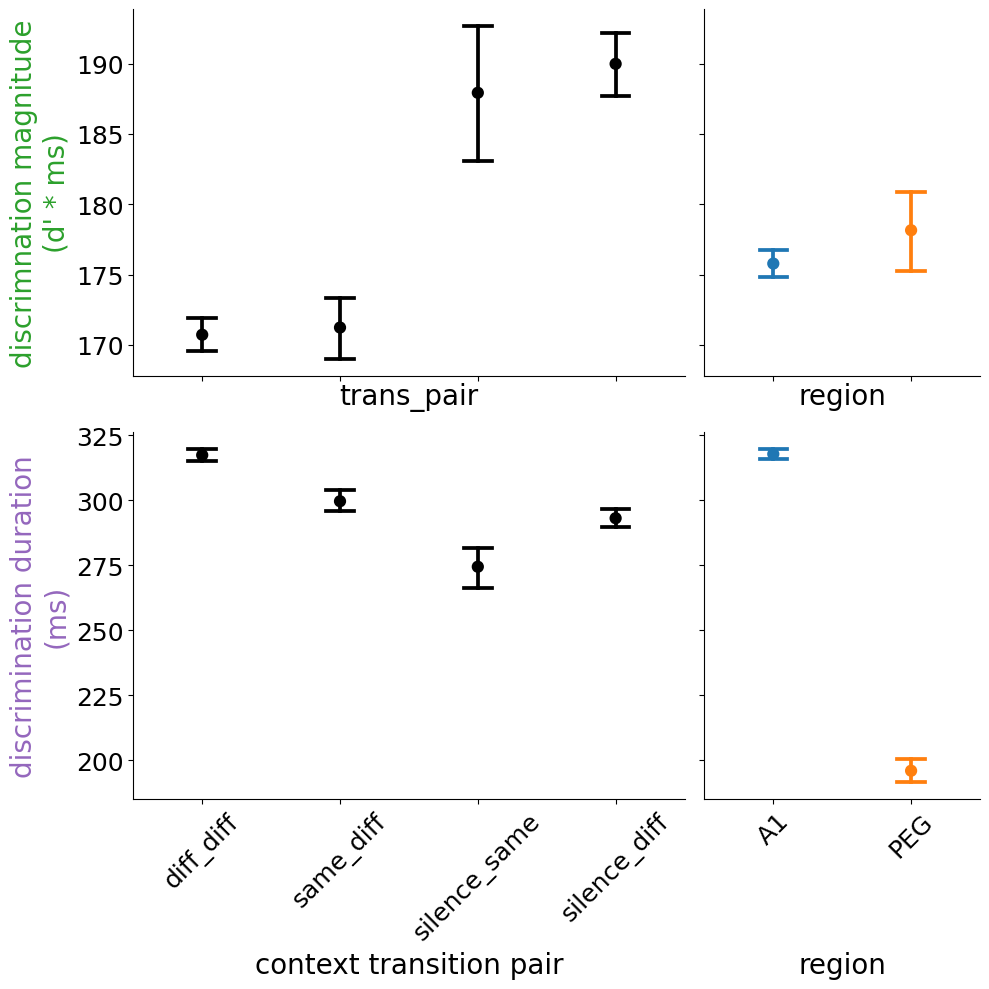

In [6]:

##############################################################################
########## figure and subplots locations #####################################
##############################################################################

gs_kw = dict(width_ratios=[1, 0.5], height_ratios=[1, 1])
fig, axes = plt.subplots(2, 2, sharex='col', sharey='row', gridspec_kw=gs_kw)
fig.set_size_inches(10, 10)

##############################################################################
########## block of simple metric comparisons#################################
##############################################################################
trans_ord = ['diff_diff', 'same_diff', 'silence_same', 'silence_diff']
reg_ord = ['A1', 'PEG']

metrics = ["integral (d'*ms)", "center of mass (ms)"]
for nn, (metric, row) in enumerate(zip(metrics, axes)):
    tocalc = filtered.loc[(filtered.metric == metric) &
                          (filtered.analysis == 'single cell') &
                          (filtered.value >0),:]

    toplot = tocalc.loc[(tocalc.value < 600), :]

    if metric == "integral (d'*ms)":
        mname = 'integral'
        ylname = "discrimnation magnitude\n(d' * ms)"
        lab_color = 'C2'
    elif metric == "center of mass (ms)":
        mname = 'center_of_mass'
        ylname = "discrimination duration\n(ms)"
        lab_color = 'C4'

    trans_ax, reg_ax = row

    #transitions
    _ = sns.pointplot(x='trans_pair', y='value', data=tocalc, order=trans_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=['black'], capsize=0.2, ci=68, ax=trans_ax)
    trans_ax.legend([],[], frameon=False)
    trans_ax.set_xticklabels(trans_ord, rotation = 45)

    if nn>0: trans_ax.set_xlabel('context transition pair')
    trans_ax.set_ylabel(ylname)
    trans_ax.yaxis.label.set_color(lab_color)

    # regions
    _ = sns.pointplot(x='region', y='value', data=tocalc, order=reg_ord, hue_order=reg_ord,
                       s=2, dodge=0.4, join=False, palette=sns.color_palette(), capsize=0.2, ci=68, ax=reg_ax)

    reg_ax.legend([],[], frameon=False)
    reg_ax.set_xticklabels(reg_ord, rotation = 45)
    if nn>0: reg_ax.set_xlabel('region')
    reg_ax.set_ylabel("")

    fig.align_labels()

### general figure layout

In [13]:
# simple plot layout and other figurewide configurations
fig = make_subplots(rows=2,cols=3, vertical_spacing=0.05, horizontal_spacing=0.05,
                    specs=[[{'rowspan':2}, {}, {}],
                           [None         , {}, {}]])

# figure size in inches at different PPIs

ppi = 300 # high quality print standard (do i need this if I do postprocecing in vectors)
ppi = 96 # www standard
ppi = 92.5 # house monitor

heigh = 4
width = heigh * 1.5 # in inches
_ = fig.update_layout(template='simple_white',
                      margin=dict(l=10, r=10, t=10, b=10),
                      width=round(ppi*width), height=round(ppi*heigh),
                      showlegend=False)

fig.print_grid()

This is the format of your plot grid:
⎡ (1,1) x,y   ⎤  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
⎣      :      ⎦  [ (2,2) x4,y4 ]  [ (2,3) x5,y5 ]



### scatter plot of all dots

In [24]:
# fig = make_subplots(1,1)
row, col = 1, 1

toplot = pivoted.loc[pivoted['center of mass (ms)']>0,:]
toplot['marker_color'] = toplot['region'].apply(lambda x: 'blue' if x=='A1' else 'orange')
toplot['hovertext'] = toplot['id'] + " ctx-pair:" + toplot['context_pair'] + " probe:" + toplot['probe'].astype(str)

_ = fig.add_trace(go.Scatter(x=toplot["center of mass (ms)"], y=toplot["integral (d'*ms)"],
                             mode='markers', marker_color=toplot['marker_color'], opacity=0.3,
                             hoverinfo='text', hovertext=toplot['hovertext']),
                  row=row, col=col)

_ = fig.update_xaxes(title=dict(text='center of mass (ms)', standoff=0),
                     row=row, col=col)
_ = fig.update_yaxes(title=dict(text="integral (d'*ms)", standoff=0),
                     row=row, col=col)

/tmp/ipykernel_1487/3629750918.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1487/3629750918.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## barplots of statistical analysis

metric     analysis region            id context_pair    trans_pair  probe  \
0        population     A1       AMT020a        00_01  silence_diff      2   
1        population     A1       AMT020a        00_01  silence_diff      3   
2        population     A1       AMT020a        00_01  silence_diff      4   
3        population     A1       AMT020a        00_01  silence_same      1   
4        population     A1       AMT020a        00_02  silence_diff      1   
...             ...    ...           ...          ...           ...    ...   
155185  single cell    PEG  CRD014b-29-1        02_04     same_diff      4   
155186  single cell    PEG  CRD014b-29-1        03_04     diff_diff      1   
155187  single cell    PEG  CRD014b-29-1        03_04     diff_diff      2   
155188  single cell    PEG  CRD014b-29-1        03_04     same_diff      3   
155189  single cell    PEG  CRD014b-29-1        03_04     same_diff      4   

metric  center of mass (ms)  integral (d'*ms)  
0                 76.552313        378.182756  
1                 65.093765        312.000201  
2                 65.916982        364.391872  
3                 65.001135        366.132903  
4                 74.041622        205.597182  
...                     ...               ...  
155185             0.000000          0.000000  
155186             0.000000          0.000000  
155187             0.000000          0.000000  
155188             0.000000          0.000000  
155189             0.000000          0.000000  

[155190 rows x 8 columns]